# Lensing bias power spectra estimation 

In [1]:
import numpy as np
# %matplotlib widget
import matplotlib.pyplot as plt
plt.rcParams.update({"text.usetex": True, "font.family": "Helvetica"})
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
import matplotlib
import matplotlib as mpl
matplotlib.rcParams['figure.figsize'] = (12,8)
plt.rcParams['lines.linewidth'] = 2.0

# Set global font sizes
mpl.rcParams['axes.labelsize'] = 24         # x/y label size
mpl.rcParams['axes.titlesize'] = 18         # subplot title size
mpl.rcParams['xtick.labelsize'] = 18        # tick labels
mpl.rcParams['ytick.labelsize'] = 18
mpl.rcParams['legend.fontsize'] = 13        # legend text
mpl.rcParams['figure.titlesize'] = 20       # optional for fig.suptitle()

import pickle as pl
# from sqlalchemy import create_engine
import healpy as hp
from tqdm import tqdm
from astropy.io import ascii

# CHANGE THIS PATH IN ORDER TO MATCH THE PATH OF YOUR PACKAGE
PATH_PACKAGE = '/home/miguel/Desktop/PlanckBIRD-lens'

In [2]:
Nsim = 400
Nsim_MF = 100
lmax_LB = 1000
lmax_P = 2048
L_LB = np.arange(lmax_LB + 1)
factor_L_LB = (L_LB*(L_LB+1))**2/(2*np.pi)
L_P = np.arange(lmax_P + 1)
factor_L_P = (L_P*(L_P+1))**2/(2*np.pi)
qe_list = ['TT', 'TE', 'EE', 'TB', 'EB']
qe_list_MV = qe_list + ['MV']
auto_spectra_qe_no_MV = [x + y for x, y in zip(qe_list, qe_list)]
auto_spectra_qe = [x + y for x, y in zip(qe_list_MV, qe_list_MV)]
noise_pairs = ['TTTT', 'TTTE', 'TTEE', 'TETE', 'TEEE', 'EEEE', 'TBTB', 'TBEB', 'EBEB']
noise_pairs_2 = ['TTTE', 'TTEE', 'TEEE', 'TBEB']

fg_names = ['no fg', 'simple fg', 'complex fg']
fg_names_ = ['no-fg', 'simple-fg', 'complex-fg']
fg_Cnames = ['No fg', 'Simple fg', 'Complex fg']
exp_names = ['\\textit{Planck}', '\\textit{LiteBIRD}', '\\textit{Planck}+\\textit{LiteBIRD}']

pairs = []
for i in range(len(qe_list)):
    for j in range(i, len(qe_list)):
        pairs.append(qe_list[i] + qe_list[j])
pairs_no_MV = list(pairs)
pairs.append('MVMV')
# Values of fsky, w2 and w4 for Planck's 80 % mask with an apodization scale of 2 degrees.
fsky = 0.7990690867106119
w2_LB = 0.7782862278400908
w4_LB = 0.7752966348731124
w2_P = 0.6788767002202918
w4_P = 0.6758500017222131

In [3]:
cls_phiphi = ascii.read(f"{PATH_PACKAGE}/input/base_2018_plikHM_TTTEEE_lowl_lowE_lensing_cl_lensed.dat",
                     format="commented_header", header_start=10).as_array()['6:phiphi'][:lmax_P + 1]*(L_P*(L_P+1))

In [4]:
fd = f'{PATH_PACKAGE}/data/MCN0_bias'
fg_arr = ['no_fg', 's1_d1_f1_a1_co1', 's5_d10_a1_f1_co3']
fname_LiteBIRD = f"LiteBIRD_fsky_0.8"
fname_Planck = f"Planck_fsky_0.7"
fname_Planck_LiteBIRD = f"LiteBIRD_Planck_fsky_0.8"

# Initialize the variables
N0_LiteBIRD = []
N0_Planck = []
N0_Planck_LiteBIRD = []
MCN0_LiteBIRD = []
MCN0_Planck = []
MCN0_Planck_LiteBIRD = []
for i, fg in enumerate(fg_arr):
    # Analytical N0 bias
    N0_LiteBIRD.append(pl.load(open(f"{fd}/N0_analytical_Nsim_400_{fg}_{fname_LiteBIRD}.pkl",'rb')))
    N0_Planck.append(pl.load(open(f"{fd}/N0_analytical_Nsim_400_{fg}_{fname_Planck}.pkl",'rb')))
    N0_Planck_LiteBIRD.append(pl.load(open(f"{fd}/N0_analytical_Nsim_400_{fg}_{fname_Planck_LiteBIRD}.pkl",'rb')))
    # MCN0 bias
    MCN0_LiteBIRD_aux = pl.load(open(f"{fd}/mean_MCN0_TT_TE_EE_TB_EB_{fg}_{fname_LiteBIRD}.pkl",'rb'))
    MCN0_Planck_aux = pl.load(open(f"{fd}/mean_MCN0_TT_TE_EE_TB_EB_{fg}_{fname_Planck}.pkl",'rb'))
    MCN0_Planck_LiteBIRD_aux = pl.load(open(f"{fd}/mean_MCN0_TT_TE_EE_TB_EB_{fg}_{fname_Planck_LiteBIRD}.pkl",'rb'))
    
    MCN0_LiteBIRD.append(MCN0_LiteBIRD_aux)
    MCN0_Planck.append(MCN0_Planck_aux)
    MCN0_Planck_LiteBIRD.append(MCN0_Planck_LiteBIRD_aux)

# N0 comparison

/tmp/ipykernel_8655/1675234071.py:65: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.tight_layout()


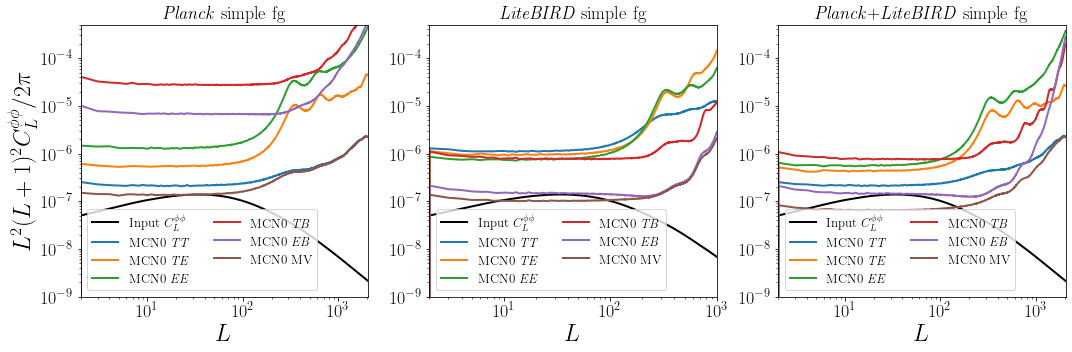

In [5]:
directory_plots = f"{PATH_PACKAGE}/notebooks/plots"

# Low complexity
fg_index = 1

fig, axes = plt.subplots(1, 3, figsize=(15, 5), constrained_layout=True)  # Three columns

# First subplot
ax = axes[0]
ax.plot(cls_phiphi, label=r'Input $C_L^{\phi\phi}$', c='k')
for qe in auto_spectra_qe:
    if qe == 'MVMV':
        qe_t = 'MV'
    else:
        qe_t = '\\textit{'+qe[:2]+'}'
    ax.plot(factor_L_P * MCN0_Planck[fg_index][qe], label=f"MCN0 {qe_t}")
ax.set_xlim([2, lmax_P])
ax.set_ylim([1e-9, 5e-4])
ax.set_xlabel(r'$L$')
ax.set_ylabel(r'$L^2(L+1)^2 C_L^{\phi\phi}/2\pi$')
ax.tick_params(axis='both', which='major')
ax.tick_params(axis='both', which='minor')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend(ncol=2, loc='lower left')
ax.set_title(f"{exp_names[0]} {fg_names[fg_index]}")

# Second subplot
ax = axes[1]
ax.plot(cls_phiphi, label=r'Input $C_L^{\phi\phi}$', c='k')
for qe in auto_spectra_qe:
    if qe == 'MVMV':
        qe_t = 'MV'
    else:
        qe_t = '\\textit{'+qe[:2]+'}'
    ax.plot(factor_L_LB * MCN0_LiteBIRD[fg_index][qe], label=f"MCN0 {qe_t}")
ax.set_xlim([2, lmax_LB])
ax.set_ylim([1e-9, 5e-4])
ax.set_xlabel(r'$L$')
ax.tick_params(axis='both', which='major')
ax.tick_params(axis='both', which='minor')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend(ncol=2, loc='lower left')
ax.set_title(f"{exp_names[1]} {fg_names[fg_index]}")

# Third subplot
ax = axes[2]
ax.plot(cls_phiphi, label=r'Input $C_L^{\phi\phi}$', c='k')
for qe in auto_spectra_qe:
    if qe == 'MVMV':
        qe_t = 'MV'
    else:
        qe_t = '\\textit{'+qe[:2]+'}'
    ax.plot(factor_L_P * MCN0_Planck_LiteBIRD[fg_index][qe], label=f"MCN0 {qe_t}")
ax.set_xlim([2, lmax_P])
ax.set_ylim([1e-9, 5e-4])
ax.set_xlabel(r'$L$')
ax.tick_params(axis='both', which='major')
ax.tick_params(axis='both', which='minor')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend(ncol=2, loc='lower left')
ax.set_title(f"{exp_names[2]} {fg_names[fg_index]}")
plt.tight_layout()
plt.savefig(f'{directory_plots}/MCN0_simple_foregrounds.pdf')

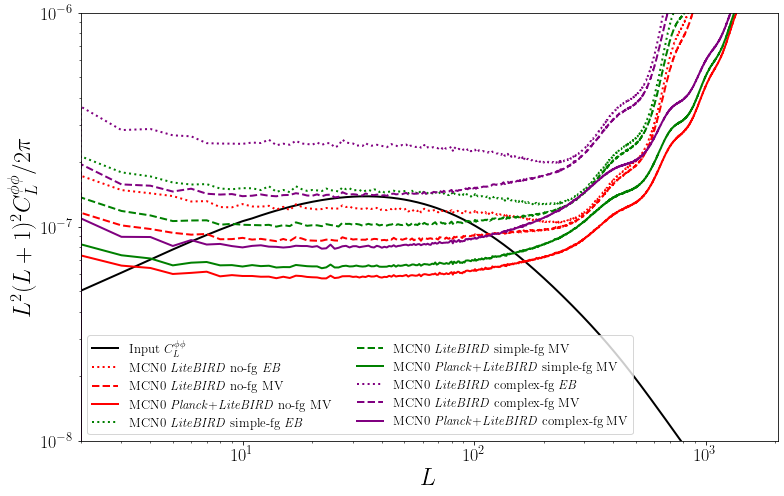

In [6]:
fg_latex = fg_names_
plt.figure(figsize=(11, 7))
plt.plot(cls_phiphi, label=r'Input $C_L^{\phi\phi}$', c='k')

qe_EB = 'EBEB'
qe_EB_ = '\\textit{EB}'
qe_MV = 'MVMV'

# No fg
plt.plot(factor_L_LB * MCN0_LiteBIRD[0][qe_EB], linestyle='dotted', label=f"MCN0 {exp_names[1]} {fg_latex[0]} {qe_EB_}", c='red')
plt.plot(factor_L_LB * MCN0_LiteBIRD[0][qe_MV], linestyle='dashed', label=f"MCN0 {exp_names[1]} {fg_latex[0]} {qe_MV[2:]}", c='red')
plt.plot(factor_L_P * MCN0_Planck_LiteBIRD[0][qe_MV], label=f"MCN0 {exp_names[2]} {fg_latex[0]} {qe_MV[2:]}", c='red')

# Low complexity foregrounds
plt.plot(factor_L_LB * MCN0_LiteBIRD[1][qe_EB], linestyle='dotted', label=f"MCN0 {exp_names[1]} {fg_latex[1]} {qe_EB_}", c='green')
plt.plot(factor_L_LB * MCN0_LiteBIRD[1][qe_MV], linestyle='dashed', label=f"MCN0 {exp_names[1]} {fg_latex[1]} {qe_MV[2:]}", c='green')
plt.plot(factor_L_P * MCN0_Planck_LiteBIRD[1][qe_MV], label=f"MCN0 {exp_names[2]} {fg_latex[1]} {qe_MV[2:]}", c='green')

# Medium complexity foregrounds
plt.plot(factor_L_LB * MCN0_LiteBIRD[2][qe_EB], linestyle='dotted', label=f"MCN0 {exp_names[1]} {fg_latex[2]} {qe_EB_}", c='purple')
plt.plot(factor_L_LB * MCN0_LiteBIRD[2][qe_MV], linestyle='dashed', label=f"MCN0 {exp_names[1]} {fg_latex[2]} {qe_MV[2:]}", c='purple')
plt.plot(factor_L_P * MCN0_Planck_LiteBIRD[2][qe_MV], label=f"MCN0 {exp_names[2]} {fg_latex[2]} {qe_MV[2:]}", c='purple')

plt.xlim([2, lmax_P])
plt.ylim([1e-8, 1e-6])
# plt.ylim([1e-7, 1e-5])
plt.xlabel(r'$L$')
plt.ylabel(r'$L^2(L+1)^2 C_L^{\phi\phi}/2\pi$')
plt.tick_params(axis='both', which='major')
plt.tick_params(axis='both', which='minor')
plt.semilogx()
plt.semilogy()
plt.legend(ncol=2, loc='lower left')
plt.tight_layout()
plt.savefig(f'{directory_plots}/comparison_MCN0.pdf')

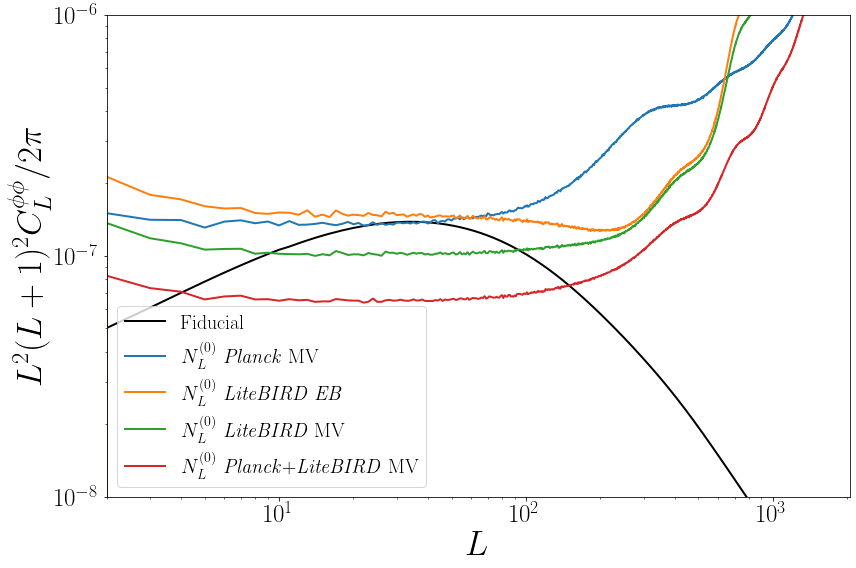

In [7]:
fg_latex = fg_names_
plt.figure(figsize=(12, 8))
plt.plot(cls_phiphi, label=r'Fiducial', c='k')

qe_EB = 'EBEB'
qe_EB_ = '\\textit{EB}'
qe_MV = 'MVMV'

# Low complexity foregrounds
plt.plot(factor_L_P * MCN0_Planck[1][qe_MV], label=r"$N_L^{(0)}$" +f" {exp_names[0]} {qe_MV[2:]}")
plt.plot(factor_L_LB * MCN0_LiteBIRD[1][qe_EB], label=r"$N_L^{(0)}$" +f" {exp_names[1]} {qe_EB_}")
plt.plot(factor_L_LB * MCN0_LiteBIRD[1][qe_MV], label=r"$N_L^{(0)}$" +f" {exp_names[1]} {qe_MV[2:]}")
plt.plot(factor_L_P * MCN0_Planck_LiteBIRD[1][qe_MV], label=r"$N_L^{(0)}$" +f" {exp_names[2]} {qe_MV[2:]}")

plt.xlim([2, lmax_P])
plt.ylim([1e-8, 1e-6])
# plt.ylim([1e-7, 1e-5])
plt.xlabel(r'$L$', size=35)
plt.ylabel(r'$L^2(L+1)^2 C_L^{\phi\phi}/2\pi$', size=35)
plt.tick_params(axis='both', which='major', labelsize=25)
plt.tick_params(axis='both', which='minor', labelsize=25)
plt.semilogx()
plt.semilogy()
# plt.title('simple-foregrounds', fontsize=24)
plt.legend(ncol=1, loc='lower left', fontsize=20)
plt.tight_layout()
# plt.savefig(f'{directory_plots}/comparison_MCN0_simple_fg.png')

# N1 comparison

In [8]:
fd = f"{PATH_PACKAGE}/data/N1_bias"
fg_arr = ['no_fg', 's1_d1_f1_a1_co1', 's5_d10_a1_f1_co3']
fname_LiteBIRD = f"LiteBIRD_fsky_0.8"
fname_Planck = f"Planck_fsky_0.7"
fname_Planck_LiteBIRD = f"LiteBIRD_Planck_fsky_0.8"

# Initialize the variables
N1_LiteBIRD = []
N1_Planck = []
N1_Planck_LiteBIRD = []
for i, fg in enumerate(fg_arr):
    # Analytical N0 bias
    N1_LiteBIRD.append(pl.load(open(f"{fd}/N1_Nsim_400_{fg}_{fname_LiteBIRD}.pkl",'rb')))
    N1_Planck.append(pl.load(open(f"{fd}/N1_Nsim_400_{fg}_{fname_Planck}.pkl",'rb')))
    N1_Planck_LiteBIRD.append(pl.load(open(f"{fd}/N1_Nsim_400_{fg}_{fname_Planck_LiteBIRD}.pkl",'rb')))

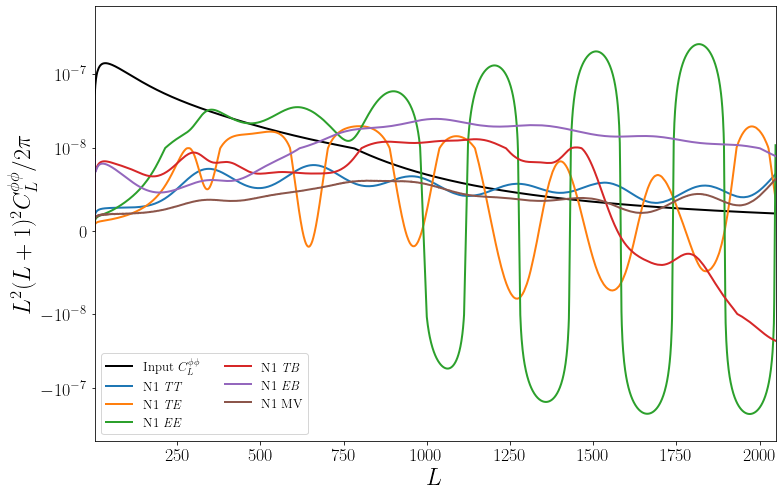

In [9]:
fg_index = 1
plt.figure(figsize=(11, 7))
plt.plot(cls_phiphi, label=r'Input $C_L^{\phi\phi}$', c='k')
for qe in qe_list:
    plt.plot(factor_L_P*(N1_Planck_LiteBIRD[fg_index][qe+qe]), label='N1 \\textit{'+f"{qe}"+'}')
plt.plot(factor_L_P*(N1_Planck_LiteBIRD[fg_index]['MVMV']), label=f"N1 MV")
plt.xlim([2, lmax_P])
plt.ylim([-5e-7, 8e-7])
# plt.semilogx()
plt.yscale('symlog', linthresh=1e-8)
# plt.title(f"{exp_names[2]} {fg_names[fg_index]}", size=25)
plt.xlabel(r'$L$')
plt.ylabel(r'$L^2(L+1)^2 C_L^{\phi\phi}/2\pi$')
plt.tick_params(axis='both', which='major')
plt.tick_params(axis='both', which='minor')
plt.legend(ncol=2, loc='lower left')
plt.tight_layout()
plt.savefig(f'{directory_plots}/N1_simple_foregrounds.pdf')

# Mean-Field (MF)

In [10]:
fd = f'{PATH_PACKAGE}/data/MF_bias'
fg_arr = ['no_fg', 's1_d1_f1_a1_co1', 's5_d10_a1_f1_co3']
fname_LiteBIRD = f"LiteBIRD_fsky_0.8"
fname_Planck = f"Planck_fsky_0.7"
fname_Planck_LiteBIRD = f"LiteBIRD_Planck_fsky_0.8"

# Initialize the variables
MF_LiteBIRD = []
MF_Planck = []
MF_Planck_LiteBIRD = []
for i, fg in enumerate(fg_arr):
    # Analytical N0 bias
    MF_LiteBIRD.append(pl.load(open(f"{fd}/MF_TT_TE_EE_TB_EB_{fg}_{fname_LiteBIRD}.pkl",'rb')))
    MF_Planck.append(pl.load(open(f"{fd}/MF_TT_TE_EE_TB_EB_{fg}_{fname_Planck}.pkl",'rb')))
    MF_Planck_LiteBIRD.append(pl.load(open(f"{fd}/MF_TT_TE_EE_TB_EB_{fg}_{fname_Planck_LiteBIRD}.pkl",'rb')))

/tmp/ipykernel_8655/3867923667.py:51: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.tight_layout()


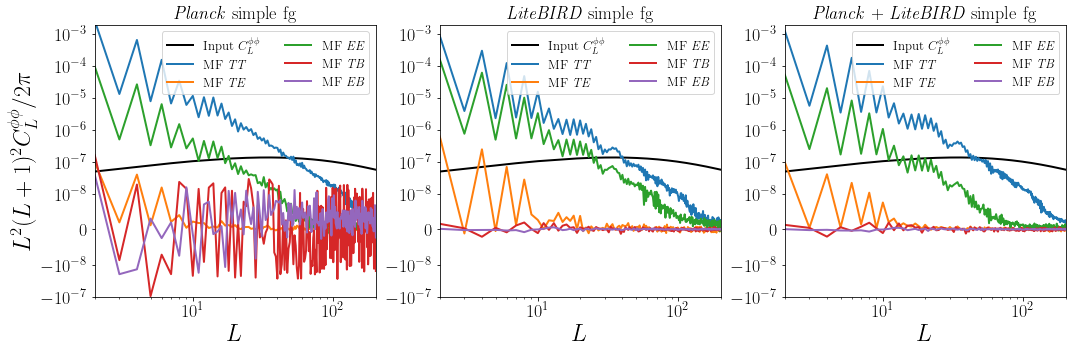

In [11]:
# Simple foregrounds
fg_index = 1
lmax_MF = 200
fig, axes = plt.subplots(1, 3, figsize=(15, 5), constrained_layout=True)  # Three columns

# First subplot
ax = axes[0]
ax.plot(cls_phiphi, label=r'Input $C_L^{\phi\phi}$', c='k')
for qe in auto_spectra_qe_no_MV:
    ax.plot(factor_L_P * MF_Planck[fg_index][qe], label='MF \\textit{'+f"{qe[:2]}"+'}')
ax.set_xlim([2, lmax_MF])
ax.set_ylim([-1e-7, 2e-3])
ax.set_xlabel(r'$L$')
ax.set_ylabel(r'$L^2(L+1)^2 C_L^{\phi\phi}/2\pi$')
ax.tick_params(axis='both', which='major')
ax.tick_params(axis='both', which='minor')
ax.set_xscale('log')
ax.set_yscale('symlog', linthresh=1e-8)
ax.legend(ncol=2, loc='upper right')
ax.set_title("\\textit{Planck} simple fg")

# Second subplot
ax = axes[1]
ax.plot(cls_phiphi, label=r'Input $C_L^{\phi\phi}$', c='k')
for qe in auto_spectra_qe_no_MV:
    ax.plot(factor_L_LB * MF_LiteBIRD[fg_index][qe], label='MF \\textit{'+f"{qe[:2]}"+'}')
ax.set_xlim([2, lmax_MF])
ax.set_ylim([-1e-7, 2e-3])
ax.set_xlabel(r'$L$')
ax.tick_params(axis='both', which='major')
ax.tick_params(axis='both', which='minor')
ax.set_xscale('log')
ax.set_yscale('symlog', linthresh=1e-8)
ax.legend(ncol=2, loc='upper right')
ax.set_title("\\textit{LiteBIRD} simple fg")

# Third subplot
ax = axes[2]
ax.plot(cls_phiphi, label=r'Input $C_L^{\phi\phi}$', c='k')
for qe in auto_spectra_qe_no_MV:
    ax.plot(factor_L_P * MF_Planck_LiteBIRD[fg_index][qe], label='MF \\textit{'+f"{qe[:2]}"+'}')
ax.set_xlim([2, lmax_MF])
ax.set_ylim([-1e-7, 2e-3])
ax.set_xlabel(r'$L$')
ax.tick_params(axis='both', which='major')
ax.tick_params(axis='both', which='minor')
ax.set_xscale('log')
ax.set_yscale('symlog', linthresh=1e-8)
ax.legend(ncol=2, loc='upper right')
ax.set_title("\\textit{Planck} + \\textit{LiteBIRD} simple fg")
plt.tight_layout()
plt.savefig(f'{directory_plots}/MF_simple_fg_lmax_{lmax_MF}.pdf')

# MV weights

In [12]:
fd = f'{PATH_PACKAGE}/data/weights_MV'
fg_arr = ['no_fg', 's1_d1_f1_a1_co1', 's5_d10_a1_f1_co3']
fname_LiteBIRD = f"LiteBIRD_fsky_0.8"
fname_Planck = f"Planck_fsky_0.7"
fname_Planck_LiteBIRD = f"LiteBIRD_Planck_fsky_0.8"

# Initialize the variables
weights_MV_LiteBIRD = []
weights_MV_Planck = []
weights_MV_Planck_LiteBIRD = []
for i, fg in enumerate(fg_arr):
    # MV weights
    weights_MV_LiteBIRD.append(pl.load(open(f"{fd}/MV_weights_400_{fg}_{fname_LiteBIRD}.pkl",'rb')))
    weights_MV_Planck.append(pl.load(open(f"{fd}/MV_weights_400_{fg}_{fname_Planck}.pkl",'rb')))
    weights_MV_Planck_LiteBIRD.append(pl.load(open(f"{fd}/MV_weights_400_{fg}_{fname_Planck_LiteBIRD}.pkl",'rb')))

/tmp/ipykernel_8655/1268377664.py:54: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.tight_layout()


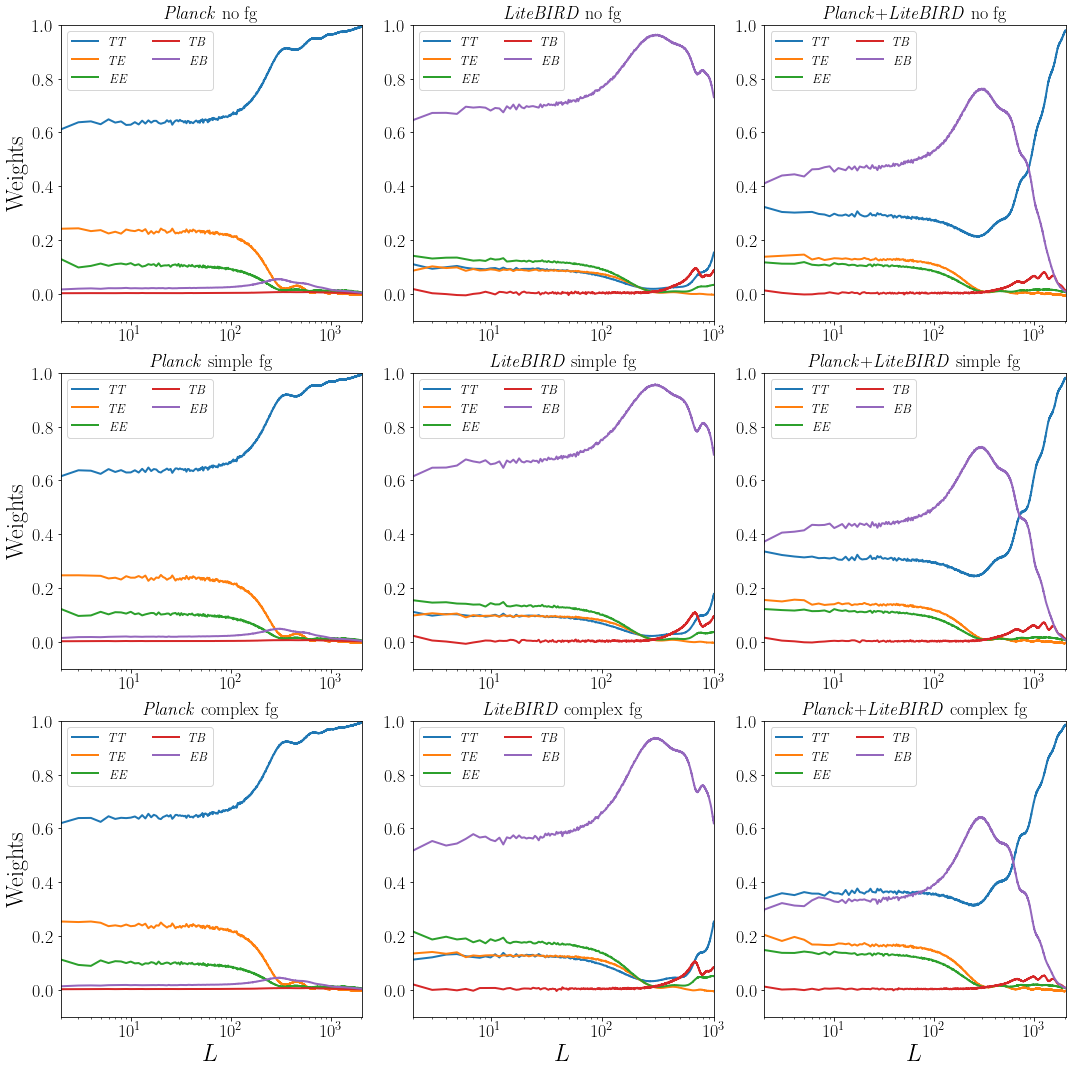

In [13]:
# No foregrounds
fg_index = 0

fig, axes = plt.subplots(3, 3, figsize=(15, 15), constrained_layout=True)  # Three columns

axes = axes.flatten()

# First subplot
ax = axes[0]
for i, qe in enumerate(qe_list):
    ax.plot(weights_MV_Planck[fg_index][qe], label='\\textit{'+f"{qe}"+'}')
    # ax.plot(weights_MV_Planck_MF[fg_index][qe], label=f"MF {qe}")
    #ax.plot(weights_MV_Planck_no_MF[fg_index][qe], linestyle='dashed', c=c[i])
ax.set_xlim([2, lmax_P])
ax.set_ylim([-0.1, 1])
# ax.set_xlabel(r'$L$', size=30)
ax.set_ylabel(r'Weights')
ax.tick_params(axis='both', which='major')
ax.tick_params(axis='both', which='minor')
ax.set_xscale('log')
ax.set_yscale('linear')
ax.legend(ncol=2, loc='upper left')
ax.set_title(f"{exp_names[0]} {fg_names[fg_index]}")

# Second subplot
ax = axes[1]
for i, qe in enumerate(qe_list):
    ax.plot(weights_MV_LiteBIRD[fg_index][qe], label='\\textit{'+f"{qe}"+'}')
    #ax.plot(weights_MV_LiteBIRD_no_MF[fg_index][qe], linestyle='dashed', c=c[i])
ax.set_xlim([2, lmax_LB])
ax.set_ylim([-0.1, 1])
# ax.set_xlabel(r'$L$', size=30)
ax.tick_params(axis='both', which='major')
ax.tick_params(axis='both', which='minor')
ax.set_xscale('log')
ax.set_yscale('linear')
ax.legend(ncol=2, loc='upper left')
ax.set_title(f"{exp_names[1]} {fg_names[fg_index]}")

# Third subplot
ax = axes[2]
for i, qe in enumerate(qe_list):
    ax.plot(weights_MV_Planck_LiteBIRD[fg_index][qe], label='\\textit{'+f"{qe}"+'}')
    #ax.plot(weights_MV_Planck_LiteBIRD_no_MF[fg_index][qe], linestyle='dashed', c=c[i])
ax.set_xlim([2, lmax_P])
ax.set_ylim([-0.1, 1])
# ax.set_xlabel(r'$L$', size=30)
ax.tick_params(axis='both', which='major')
ax.tick_params(axis='both', which='minor')
ax.set_xscale('log')
ax.set_yscale('linear')
ax.legend(ncol=2, loc='upper left')
ax.set_title(f"{exp_names[2]} {fg_names[fg_index]}")
plt.tight_layout()

# Low complexity
fg_index = 1

# First subplot
ax = axes[3]
for i, qe in enumerate(qe_list):
    ax.plot(weights_MV_Planck[fg_index][qe], label='\\textit{'+f"{qe}"+'}')
    # ax.plot(weights_MV_Planck_MF[fg_index][qe], label=f"MF {qe}")
    #ax.plot(weights_MV_Planck_no_MF[fg_index][qe], linestyle='dashed', c=c[i])
ax.set_xlim([2, lmax_P])
ax.set_ylim([-0.1, 1])
# ax.set_xlabel(r'$L$', size=30)
ax.set_ylabel(r'Weights')
ax.tick_params(axis='both', which='major')
ax.tick_params(axis='both', which='minor')
ax.set_xscale('log')
ax.set_yscale('linear')
ax.legend(ncol=2, loc='upper left')
ax.set_title(f"{exp_names[0]} {fg_names[fg_index]}")

# Second subplot
ax = axes[4]
for i, qe in enumerate(qe_list):
    ax.plot(weights_MV_LiteBIRD[fg_index][qe], label='\\textit{'+f"{qe}"+'}')
    #ax.plot(weights_MV_LiteBIRD_no_MF[fg_index][qe], linestyle='dashed', c=c[i])
ax.set_xlim([2, lmax_LB])
ax.set_ylim([-0.1, 1])
# ax.set_xlabel(r'$L$', size=30)
ax.tick_params(axis='both', which='major')
ax.tick_params(axis='both', which='minor')
ax.set_xscale('log')
ax.set_yscale('linear')
ax.legend(ncol=2, loc='upper left')
ax.set_title(f"{exp_names[1]} {fg_names[fg_index]}")

# Third subplot
ax = axes[5]
for i, qe in enumerate(qe_list):
    ax.plot(weights_MV_Planck_LiteBIRD[fg_index][qe], label='\\textit{'+f"{qe}"+'}')
    #ax.plot(weights_MV_Planck_LiteBIRD_no_MF[fg_index][qe], linestyle='dashed', c=c[i])
ax.set_xlim([2, lmax_P])
ax.set_ylim([-0.1, 1])
# ax.set_xlabel(r'$L$', size=30)
ax.tick_params(axis='both', which='major')
ax.tick_params(axis='both', which='minor')
ax.set_xscale('log')
ax.set_yscale('linear')
ax.legend(ncol=2, loc='upper left')
ax.set_title(f"{exp_names[2]} {fg_names[fg_index]}")
plt.tight_layout()

# Low complexity
fg_index = 2

axes = axes.flatten()

# First subplot
ax = axes[6]
for i, qe in enumerate(qe_list):
    ax.plot(weights_MV_Planck[fg_index][qe], label='\\textit{'+f"{qe}"+'}')
    # ax.plot(weights_MV_Planck_MF[fg_index][qe], label=f"MF {qe}")
    #ax.plot(weights_MV_Planck_no_MF[fg_index][qe], linestyle='dashed', c=c[i])
ax.set_xlim([2, lmax_P])
ax.set_ylim([-0.1, 1])
ax.set_xlabel(r'$L$')
ax.set_ylabel(r'Weights')
ax.tick_params(axis='both', which='major')
ax.tick_params(axis='both', which='minor')
ax.set_xscale('log')
ax.set_yscale('linear')
ax.legend(ncol=2, loc='upper left')
ax.set_title(f"{exp_names[0]} {fg_names[fg_index]}")

# Second subplot
ax = axes[7]
for i, qe in enumerate(qe_list):
    ax.plot(weights_MV_LiteBIRD[fg_index][qe], label='\\textit{'+f"{qe}"+'}')
    #ax.plot(weights_MV_LiteBIRD_no_MF[fg_index][qe], linestyle='dashed', c=c[i])
ax.set_xlim([2, lmax_LB])
ax.set_ylim([-0.1, 1])
ax.set_xlabel(r'$L$')
ax.tick_params(axis='both', which='major')
ax.tick_params(axis='both', which='minor')
ax.set_xscale('log')
ax.set_yscale('linear')
ax.legend(ncol=2, loc='upper left')
ax.set_title(f"{exp_names[1]} {fg_names[fg_index]}")

# Third subplot
ax = axes[8]
for i, qe in enumerate(qe_list):
    ax.plot(weights_MV_Planck_LiteBIRD[fg_index][qe], label='\\textit{'+f"{qe}"+'}')
    #ax.plot(weights_MV_Planck_LiteBIRD_no_MF[fg_index][qe], linestyle='dashed', c=c[i])
ax.set_xlim([2, lmax_P])
ax.set_ylim([-0.1, 1])
ax.set_xlabel(r'$L$')
ax.tick_params(axis='both', which='major')
ax.tick_params(axis='both', which='minor')
ax.set_xscale('log')
ax.set_yscale('linear')
ax.legend(ncol=2, loc='upper left')
ax.set_title(f"{exp_names[2]} {fg_names[fg_index]}")
plt.tight_layout()
plt.savefig(f'{directory_plots}/Weights_MV_all.pdf')

# MONTE CARLO NORMALIZATION CORRECTION $R_L^{\rm MC}$

In [14]:
fd = f'{PATH_PACKAGE}/data/R_MC'
fg_arr = ['no_fg', 's1_d1_f1_a1_co1', 's5_d10_a1_f1_co3']
fname_LiteBIRD = f"LiteBIRD_fsky_0.8"
fname_Planck = f"Planck_fsky_0.7"
fname_Planck_LiteBIRD = f"LiteBIRD_Planck_fsky_0.8"

# Initialize the variables
R_MC_LiteBIRD = []
R_MC_Planck = []
R_MC_Planck_LiteBIRD = []
for i, fg in enumerate(fg_arr):
    # MV weights
    R_MC_LiteBIRD_aux = pl.load(open(f"{fd}/R_MC_TT_TE_EE_TB_EB_{fg}_{fname_LiteBIRD}_Nsim_400_new.pkl",'rb'))
    R_MC_Planck_aux = pl.load(open(f"{fd}/R_MC_TT_TE_EE_TB_EB_{fg}_{fname_Planck}_Nsim_400_new.pkl",'rb'))
    R_MC_Planck_LiteBIRD_aux = pl.load(open(f"{fd}/R_MC_TT_TE_EE_TB_EB_{fg}_{fname_Planck_LiteBIRD}_Nsim_400_new.pkl",'rb'))
    
    R_MC_LiteBIRD.append({qe: R_MC_LiteBIRD_aux[qe] for qe in qe_list_MV})
    R_MC_Planck.append({qe: R_MC_Planck_aux[qe] for qe in qe_list_MV})
    R_MC_Planck_LiteBIRD.append({qe: R_MC_Planck_LiteBIRD_aux[qe] for qe in qe_list_MV})

/tmp/ipykernel_8655/1655212247.py:55: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.tight_layout()


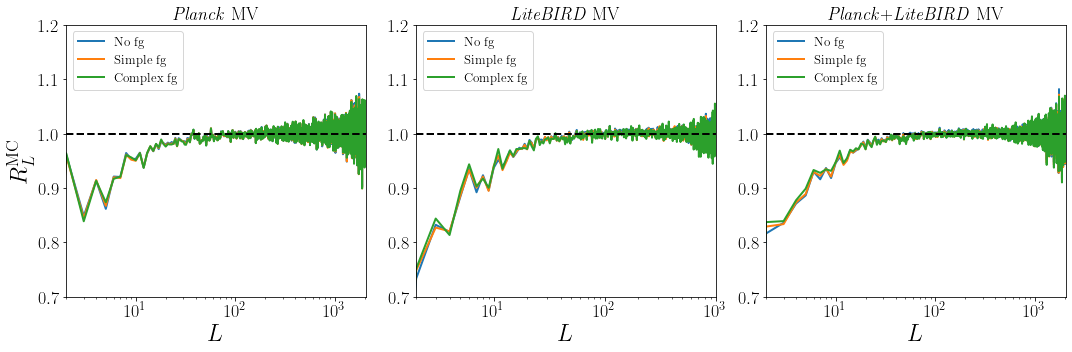

In [15]:
# Medium complexity
fg_index = 2

fig, axes = plt.subplots(1, 3, figsize=(15, 5), constrained_layout=True)  # Three columns

c = ['b', 'g', 'r', 'c', 'm', 'y']
# First subplot
ax = axes[0]
qe = 'MV'
for fg_index in range(3):
    ax.plot(R_MC_Planck[fg_index][qe]/(w4_P/w2_P), label=f"{fg_Cnames[fg_index]}")
ax.axhline(y=1.0, linestyle='dashed', c='k')
ax.set_xlim([2, lmax_P])
ax.set_ylim([0.7, 1.2])
ax.set_xlabel(r'$L$')
ax.set_ylabel(r'$R_L^{\mathrm{MC}}$')
ax.tick_params(axis='both', which='major')
ax.tick_params(axis='both', which='minor')
ax.set_xscale('log')
ax.set_yscale('linear')
ax.legend(ncol=1, loc='upper left')
ax.set_title(f"{exp_names[0]} MV")

# Second subplot
ax = axes[1]
qe = 'MV'
for fg_index in range(3):
    ax.plot(R_MC_LiteBIRD[fg_index][qe]/(w4_LB/w2_LB), label=f"{fg_Cnames[fg_index]}")
ax.axhline(y=1.0, linestyle='dashed', c='k')
ax.set_xlim([2, lmax_LB])
ax.set_ylim([0.7, 1.2])
ax.set_xlabel(r'$L$')
ax.tick_params(axis='both', which='major')
ax.tick_params(axis='both', which='minor')
ax.set_xscale('log')
ax.set_yscale('linear')
ax.legend(ncol=1, loc='upper left')
ax.set_title(f"{exp_names[1]} MV")

# Third subplot
ax = axes[2]
qe = 'MV'
for fg_index in range(3):
    ax.plot(R_MC_Planck_LiteBIRD[fg_index][qe]/(w4_LB/w2_LB), label=f"{fg_Cnames[fg_index]}")
ax.axhline(y=1.0, linestyle='dashed', c='k')
ax.set_xlim([2, lmax_P])
ax.set_ylim([0.7, 1.2])
ax.set_xlabel(r'$L$')
ax.tick_params(axis='both', which='major')
ax.tick_params(axis='both', which='minor')
ax.set_xscale('log')
ax.set_yscale('linear')
ax.legend(ncol=1, loc='upper left')
ax.set_title(f"{exp_names[2]} MV")
plt.tight_layout()
plt.savefig(f'{directory_plots}/R_MC_MV_all.pdf')